In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report, accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
import joblib

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
%matplotlib inline

In [4]:
rainfall = pd.read_csv("/content/weatherAUS.csv")
df_rainfall = pd.DataFrame(rainfall)
df_rainfall.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
df_rainfall.shape

(145460, 23)

In [6]:
df_rainfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [7]:
(df_rainfall.isna().sum()/df_rainfall.shape[0]) * 100

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

In [8]:
df_rainfall.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [9]:
df_rainfall.Date.value_counts().head(10)

2016-04-26    49
2015-04-25    49
2015-07-26    49
2013-10-06    49
2016-06-20    49
2015-08-02    49
2013-08-19    49
2014-07-13    49
2015-11-17    49
2016-11-20    49
Name: Date, dtype: int64

In [10]:
df_rainfall['RainToday'] = df_rainfall['RainToday'].map({'No':0, 'Yes':1})
df_rainfall['RainTomorrow'] = df_rainfall['RainTomorrow'].map({'No':0, 'Yes':1})

In [11]:
df_rainfall.RainToday.value_counts(normalize=True)

0.0    0.775807
1.0    0.224193
Name: RainToday, dtype: float64

In [12]:
df_rainfall.RainTomorrow.value_counts(normalize=True)

0.0    0.775819
1.0    0.224181
Name: RainTomorrow, dtype: float64

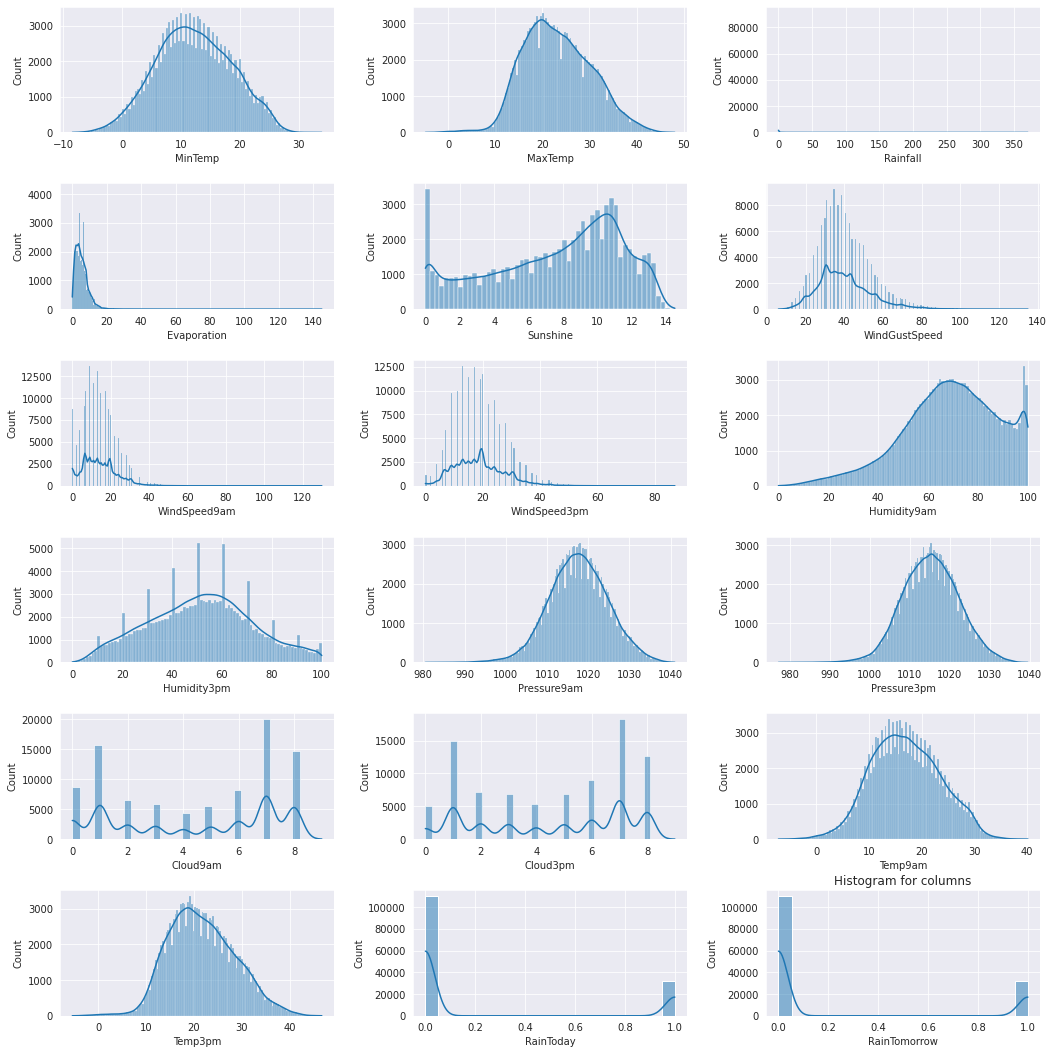

In [13]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15,15))
axes = axes.reshape(-1)
continous = [col for col in df_rainfall.columns if df_rainfall[col].dtype!= object]

for i, n in enumerate(continous):
    sns.histplot(data = df_rainfall, x = n, ax=axes[i], kde=True)
fig.tight_layout(pad=2.0)
plt.title("Histogram for columns")
plt.show()

(0.0, 1.0)

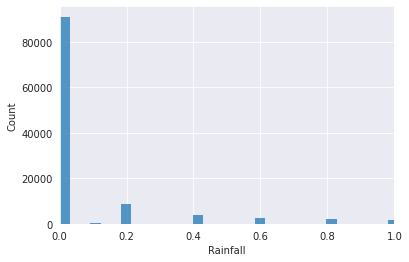

In [14]:
sns.histplot(df_rainfall['Rainfall'])
plt.xlim(0,1)

In [15]:
df_rainby_loc = df_rainfall.groupby('Location')[['RainToday']].sum()

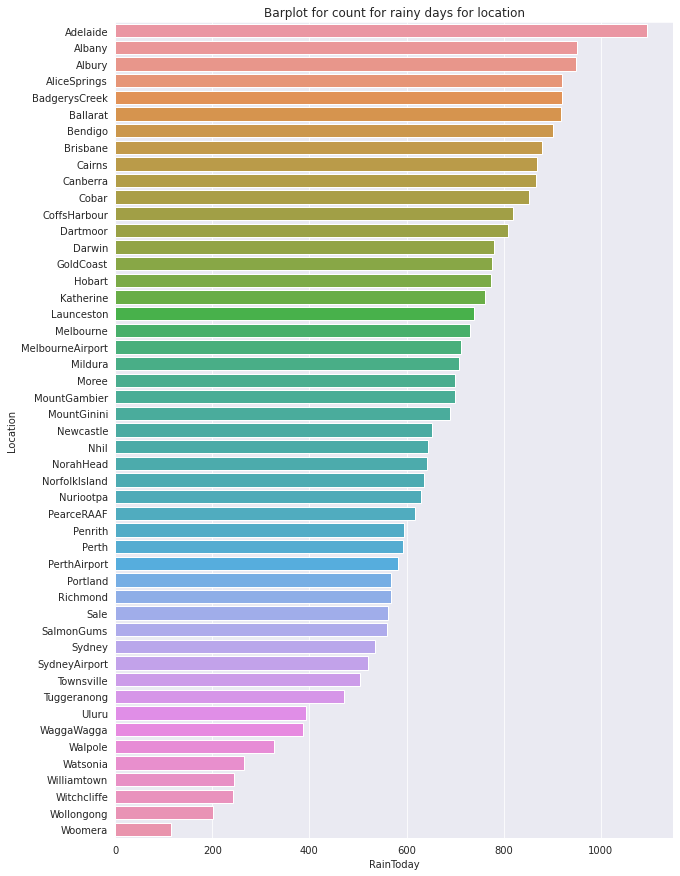

In [16]:
plt.figure(figsize=(10,15))
sns.barplot(x = 'RainToday', y =df_rainby_loc.index, data = df_rainby_loc.sort_values('RainToday',
                                                                           ascending = False))
plt.title("Barplot for count for rainy days for location")
plt.show()

In [17]:
df_rainfall.Location.value_counts()

Canberra            3436
Sydney              3344
Melbourne           3193
Brisbane            3193
Darwin              3193
Hobart              3193
Perth               3193
Adelaide            3193
Bendigo             3040
MountGambier        3040
Cairns              3040
Ballarat            3040
MountGinini         3040
Albury              3040
Launceston          3040
Townsville          3040
AliceSprings        3040
GoldCoast           3040
Albany              3040
Wollongong          3040
Tuggeranong         3039
Newcastle           3039
Penrith             3039
Williamtown         3009
MelbourneAirport    3009
NorfolkIsland       3009
BadgerysCreek       3009
Portland            3009
Dartmoor            3009
Mildura             3009
SydneyAirport       3009
Nuriootpa           3009
Moree               3009
Sale                3009
Cobar               3009
Richmond            3009
Witchcliffe         3009
CoffsHarbour        3009
WaggaWagga          3009
Woomera             3009


In [18]:
df_rainfall['Month'] = df_rainfall.Date.apply(lambda x : int(x[5:7]))

In [19]:
df_monthly_rainfall = df_rainfall.groupby('Month')[['RainToday']].mean()
df_monthly_rainfall

,RainToday
Month,
1,0.189484
2,0.206746
3,0.217135
4,0.216845
5,0.222163
6,0.263638
7,0.270736
8,0.253167
9,0.229135


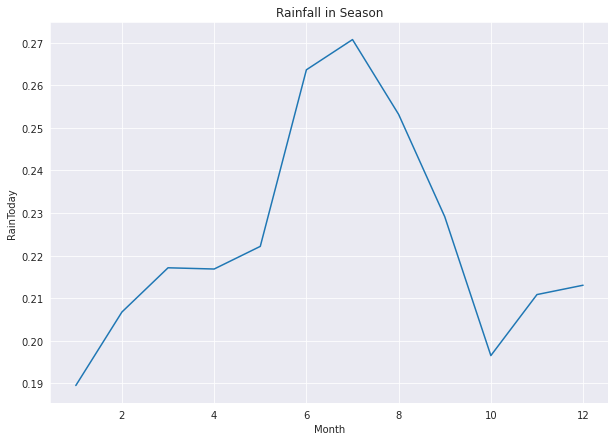

In [20]:
plt.figure(figsize=(10,7))
sns.lineplot(data = df_monthly_rainfall, x = 'Month', y= 'RainToday')
plt.title("Rainfall in Season")
plt.show()

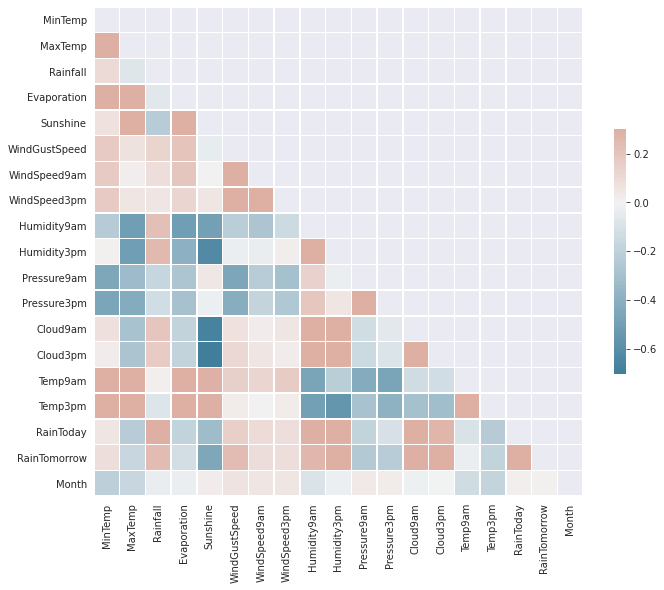

In [21]:
corr = df_rainfall.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [22]:
df_imputed = df_rainfall.dropna(axis=0, subset=['RainTomorrow'])
df_imputed.isna().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
Month                0
dtype: int64

In [23]:
df_dt_loc = df_imputed[['Date', 'Location']]

In [24]:
cont_feats = [col for col in df_imputed.columns if df_imputed[col].dtype != object]
cont_feats.remove('RainTomorrow')
cont_feats

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'Month']

In [ ]:
imputer = IterativeImputer(random_state=42)
df_imputed_cont = imputer.fit_transform(df_imputed[cont_feats])
df_imputed_cont = pd.DataFrame(df_imputed_cont, columns=cont_feats)
df_imputed_cont.head()

In [ ]:
df_imputed_cont.isna().sum()

In [ ]:
cat_feat = [col for col in df_imputed.columns if col not in cont_feats]
cat_feat.remove('Date')
cat_feat.remove('Location')
cat_feat.remove('RainTomorrow')
cat_feat

df_imputed_cat = df_imputed[cat_feat]


In [ ]:
def impute_nan_most_frequent_category(DataFrame,ColName):
    
    # .mode()[0] - gives first category name
    most_frequent_category=DataFrame[ColName].mode()[0]        
    
    # replace nan values with most occured category
    DataFrame[ColName].fillna(most_frequent_category,inplace=True)
    

In [ ]:
for col in cat_feat:
    impute_nan_most_frequent_category(df_imputed_cat, col)

In [ ]:
df_imputed_cat.isna().sum()

In [ ]:
df_target = df_imputed.RainTomorrow
print(df_imputed_cont.shape)
print(df_imputed_cat.shape)
print(df_target.shape)

In [ ]:
df_imputed_final = pd.concat(objs=[df_dt_loc.reset_index(drop=True),
                                   df_imputed_cat.reset_index(drop=True),
                                   df_imputed_cont.reset_index(drop=True), 
                                   df_target.reset_index(drop=True)], axis=1)
df_imputed_final.shape

In [ ]:
df_imputed_final.head()

In [ ]:
df_imputed_final.isna().sum()

In [ ]:
df_imputed_final.info()

In [ ]:
df_imputed_final_ = df_imputed_final.drop('Date', axis = 1)

In [ ]:
df_imputed_final_.head()

In [ ]:
df_imputed_final_.columns

In [ ]:
cat = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
df_dummies = pd.get_dummies(df_imputed_final_, columns=cat)
df_dummies.head()

In [ ]:
print(df_dummies.columns.to_list())

In [ ]:
df_final_rainfallpred = df_dummies
X = df_final_rainfallpred.drop('RainTomorrow', axis = 1)
y = df_final_rainfallpred['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
print("Training size:", X_train.shape[0])
print("Testing size:", X_test.shape[0])

In [ ]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

In [ ]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

In [ ]:
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [46]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.77704014177614
SCORE:
0.7770401

In [47]:
print(best_hyperparams)

{'colsample_bytree': 0.8711292840684453, 'gamma': 2.7001752147474036, 'max_depth': 4.0, 'min_child_weight': 6.0, 'reg_alpha': 40.0, 'reg_lambda': 0.5857405975603123}


In [48]:
xgb_ = XGBClassifier(colsample_bytree = 0.6808521597928148, gamma = 8.702538114999903, max_depth = 17, 
                    min_child_weight = 5.0, reg_alpha = 158.0, reg_lambda = 0.6755553225499079,random_state=42)
xgb_.fit(X_train, y_train)
y_pred_xgb = xgb_.predict(X_test)
y_pred_xgb

array([1., 0., 0., ..., 0., 0., 1.])

In [86]:
def conf_matrix(model, X_test, y_test, cmap='Blues'):
    plot_confusion_matrix(model, X_test, y_test, cmap=cmap)
    plt.grid()
    plt.show()

def roc_curve_custom(model, X_test, y_test):
    plot_roc_curve(model, X_test, y_test)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.show()
    
def evaluate(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, y_pred=y_pred_xgb):
    # Confusion Matrix
    print('Confusion Matrix')
    print('-'*53)
    conf_matrix(model, X_test, y_test)
    print('\n') 
    
    # Classification Report
    print('Classification Report') 
    print('-'*53)
    print(classification_report(y_test, y_pred))
    print('\n')
    
    # ROC Curve
    print('ROC Curve')
    print('-'*53)
    roc_curve_custom(model, X_test, y_test)
    print('\n')
    
    # Checking model fitness
    print('Checking model fitness') 
    print('-'*53)
    print('Train score:', round(model.score(X_train, y_train), 4))
    print('Test score: ', round(model.score(X_test, y_test), 4))
    print('\n')

In [ ]:
evaluate(xgb_, y_pred=y_pred_xgb)

In [51]:
##Random Forest Classifier

In [52]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_rf

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total= 1.2min
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total= 1.2min
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total= 1.2min
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total= 1.2min
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total= 1.2min
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total= 2.2min
[CV] n_estimators=1100, min_samples_split=10, mi

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 248.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
evaluate(rf, y_pred=y_pred_rf)

In [ ]:
rf_params = {
    'n_estimators': [10, 35, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 7, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'random_state': [42]
}

rf_gs = GridSearchCV(rf, param_grid=rf_params, scoring='accuracy', n_jobs=-1, cv=3)
rf_gs.fit(X_train, y_train)

In [ ]:
rf_gs.best_params_

In [ ]:
y_pred_rf_gs = rf_gs.predict(X_test)
y_pred_rf_gs

In [ ]:
evaluate(rf_gs, y_pred=y_pred_rf_gs)

In [64]:
joblib.dump(rf_gs, 'rf.joblib')

['rf.joblib']

In [60]:
import pickle
file = open('rainforest_classifier.pkl', 'wb')
pickle.dump(rf_gs, file)
file.close() 

In [ ]:
from google.colab import files
files.download('/content/sample_data/rainforest_classifier.pkl')